In [25]:
import cv2
import re
import os
import shutil
import random
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [2]:
# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls '/content/gdrive/My Drive'

'Atelier 3_Hive.gdoc'
 AttestationDeStage.pdf
'CH5_Déplacement des données.gdoc'
 Classroom
'Colab Notebooks'
'CV_KalthoumDridi (1).pdf'
 CV_KalthoumDridi.pdf
'Doc 2.1 Questions de compréhension orale - Kalthoum Dridi.gdoc'
'Edited - Kalthoum Dridi - ss handouts.pdf'
'English Project'
'EXAMEN_ADF (1).gdoc'
 EXAMEN_ADF.gdoc
'groupes_3A23 (1).gsheet'
 groupes_3A23.gsheet
'install spark 3 windows -.gdoc'
 JournalDeStage.pdf
'Kalthoum Dridi - 3.1 Activité sur la reformulation.gdoc'
'KalthoumDridiDocuments (1).pdf'
'KalthoumDridiDocuments (2).pdf'
'KalthoumDridiDocuments (3).pdf'
'KalthoumDridiDocuments (4).pdf'
 KalthoumDridiDocuments.pdf
 Learning-Log-Template_Reflect-on-your-skills-and-expectations.gdoc
'Learning Log Template: Think about data in daily life.gdoc'
'NWPU VHR-10 dataset.rar'
 PDFs.pdf
 PIDev
'Product Backlog.gsheet'
 RapportDeStage.pdf
'td 5 analyse syntaxique.gdoc'
'The Sweetest Oblivion - Danielle Lori.epub'
 TP3-Régression-linéaire.gdoc
'TP WEB_2023-2024.gdoc'
'Unt

In [4]:
rar_file_path = '/content/gdrive/My Drive/NWPU VHR-10 dataset.rar'

In [5]:
extract_folder_path = '/content/extracted_folder/'

In [6]:
!sudo apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [7]:
!unrar x "{rar_file_path}" "{extract_folder_path}"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/gdrive/My Drive/NWPU VHR-10 dataset.rar

Creating    /content/extracted_folder                                 OK
Creating    /content/extracted_folder/NWPU VHR-10 dataset             OK
Creating    /content/extracted_folder/NWPU VHR-10 dataset/ground truth  OK
Extracting  /content/extracted_folder/NWPU VHR-10 dataset/ground truth/001.txt       0%  OK 
Extracting  /content/extracted_folder/NWPU VHR-10 dataset/ground truth/002.txt       0%  OK 
Extracting  /content/extracted_folder/NWPU VHR-10 dataset/ground truth/003.txt       0%  OK 
Extracting  /content/extracted_folder/NWPU VHR-10 dataset/ground truth/004.txt       0%  OK 
Extracting  /content/extracted_folder/NWPU VHR-10 dataset/ground truth/005.txt       0%  OK 
Extracting  /content/extracted_folder/NWPU VHR-10 dataset/ground truth/006.txt       0%  OK 
Extracting  /content/extr

In [8]:
!ls "{extract_folder_path}"

'NWPU VHR-10 dataset'


In [19]:
import os
import shutil
import random

# Path to the folder containing images and ground truth text files
data_folder = '/content/extracted_folder/NWPU VHR-10 dataset/'

# Path to the images folder
images_folder = os.path.join(data_folder, 'positive image set')

# Path to the negative folder
negative_folder = os.path.join(data_folder, 'negative image set')

# Path to the ground truth folder
ground_truth_folder = os.path.join(data_folder, 'ground truth')


In [16]:
def load_images(image_folder):
    images = []
    for filename in os.listdir(image_folder):
        img = cv2.imread(os.path.join(image_folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        images.append(img)
    return images

In [17]:
def create_binary_masks(image_size, annotations):
    masks = np.zeros(image_size, dtype=np.uint8)
    for annotation in annotations:
        cv2.rectangle(masks, (annotation[0][0], annotation[0][1]), (annotation[1][0], annotation[1][1]), 255, -1)
    return masks

In [18]:
def read_annotations(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        annotations = []
        for line in lines:
            match = re.findall(r'\d+', line)
            if match:
                annotations.append([(int(match[0]), int(match[1])), (int(match[2]), int(match[3]))])
        return annotations

In [30]:
negative_images = load_images(negative_folder)
positive_images = load_images(images_folder)

# Extract annotations for positive images
positive_annotations = []
for filename in os.listdir(ground_truth_folder):
    if filename.endswith('.txt'):
        annotation_file_path = os.path.join(ground_truth_folder, filename)
        annotations = read_annotations(annotation_file_path)
        positive_annotations.append(annotations)

In [31]:
positive_masks = []
for annotations in positive_annotations:
    mask = create_binary_masks(positive_images[0].shape[:2], annotations)
    positive_masks.append(mask)

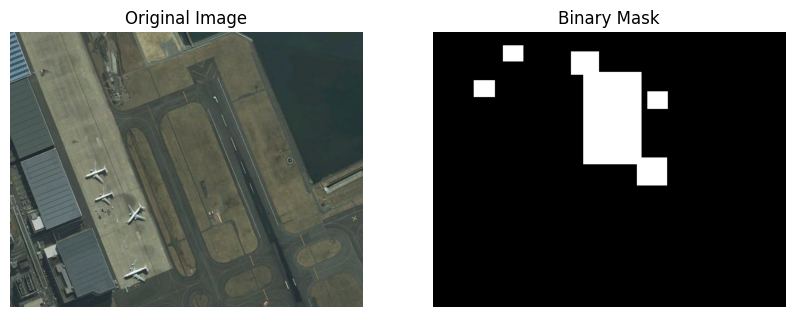

In [33]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_images[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(positive_masks[0], cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.show()

#resize images

In [11]:
from PIL import Image, ImageOps
import os

# Desired size
new_width, new_height = 1024, 1024

# Directories
image_folder = '/content/extracted_folder/NWPU VHR-10 dataset/positive image set'
annotation_folder = '/content/extracted_folder/NWPU VHR-10 dataset/ground truth'
resized_image_folder = '/content/extracted_folder/NWPU VHR-10 dataset/resized_images'  # Ensure this folder exists
adjusted_annotation_folder = '/content/extracted_folder/NWPU VHR-10 dataset/updated_ground_truth'

os.makedirs(resized_image_folder, exist_ok=True)
os.makedirs(adjusted_annotation_folder, exist_ok=True)

def resize_and_adjust(image_path, annotation_file, output_image_path, output_annotation_path):
    with Image.open(image_path) as img:
        # Get original dimensions
        orig_width, orig_height = img.size

        # Resize image using LANCZOS resampling (formerly ANTIALIAS)
        img = img.resize((new_width, new_height), Image.LANCZOS)
        img.save(output_image_path)

    # Adjust annotations
    with open(annotation_file, 'r') as file:
        lines = file.readlines()

    with open(output_annotation_path, 'w') as file:
        for line in lines:
            if ',' not in line:
                continue
            coords, class_id = line.strip().rsplit(',', 1)
            xmin, ymin = map(int, coords.split('),(')[0][1:].split(','))
            xmax, ymax = map(int, coords.split('),(')[1][:-1].split(','))

            # Scale the bounding box coordinates
            xmin_scaled = int((xmin / orig_width) * new_width)
            xmax_scaled = int((xmax / orig_width) * new_width)
            ymin_scaled = int((ymin / orig_height) * new_height)
            ymax_scaled = int((ymax / orig_height) * new_height)

            # Write adjusted annotation
            file.write(f"({xmin_scaled},{ymin_scaled}),({xmax_scaled},{ymax_scaled}),{class_id}\n")

# Process all files
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(image_folder, filename)
        annotation_file = os.path.join(annotation_folder, filename.replace('.jpg', '.txt'))

        output_image_path = os.path.join(resized_image_folder, filename)  # Ensure 'resized' folder exists
        output_annotation_path = os.path.join(adjusted_annotation_folder, filename.replace('.jpg', '.txt'))  # Ensure 'adjusted' folder exists

        resize_and_adjust(image_path, annotation_file, output_image_path, output_annotation_path)

print("Processing complete. Images and annotations have been resized and adjusted.")

Processing complete. Images and annotations have been resized and adjusted.


#modification of txt files format

In [12]:
from PIL import Image
import pandas as pd

# Path to the folder containing images and ground truth text files
data_folder = '/content/extracted_folder/NWPU VHR-10 dataset/'

# Path to the images folder
images_folder = os.path.join(data_folder, 'resized_images')

# Path to the ground truth folder
ground_truth_folder = os.path.join(data_folder, 'updated_ground_truth')

data = {
    "filename": [],
    "width": [],
    "height": [],
    "class": [],
    "xmin": [],
    "xmax": [],
    "ymin": [],
    "ymax": []
}

# Iterate over the annotation files
for filename in os.listdir(ground_truth_folder):
    if filename.endswith(".txt") and not filename.startswith("."):
        image_path = os.path.join(images_folder, filename.replace('.txt', '.jpg'))
        annotation_path = os.path.join(ground_truth_folder, filename)

        # Open the image to get its dimensions
        with Image.open(image_path) as img:
            width, height = img.size

        # Open the corresponding annotation file and process lines
        with open(annotation_path, 'r') as file:
            lines = file.read().strip().split('\n')
            for line in lines:
                # Process line to remove parentheses and split correctly
                line = line.replace('(', '').replace(')', '')
                parts = line.split(',')
                xmin = int(parts[0])
                ymin = int(parts[1])
                xmax = int(parts[2])
                ymax = int(parts[3])
                class_id = parts[4]  # the class ID

                # Append data to lists
                data['filename'].append(os.path.basename(image_path))
                data['width'].append(width)
                data['height'].append(height)
                data['class'].append(class_id)
                data['xmin'].append(xmin)
                data['xmax'].append(xmax)
                data['ymin'].append(ymin)
                data['ymax'].append(ymax)

# Create DataFrame
df = pd.DataFrame(data)
print(df)

# Optionally, save the DataFrame to a CSV fil


     filename  width  height class  xmin  xmax  ymin  ymax
0     254.jpg   1024    1024     7   508   704   225   747
1     254.jpg   1024    1024     4   466   560   109   240
2     254.jpg   1024    1024     4   689   791   710   867
3     254.jpg   1024    1024     4   725   793   335   433
4     254.jpg   1024    1024     4   137   208   272   366
...       ...    ...     ...   ...   ...   ...   ...   ...
3891  349.jpg   1024    1024     5   382   462   403   506
3892  349.jpg   1024    1024     5   423   503   361   462
3893  290.jpg   1024    1024     2   241   280   344   439
3894  290.jpg   1024    1024     2   207   261   532   621
3895  290.jpg   1024    1024     2   160   210   821   906

[3896 rows x 8 columns]


In [13]:
# center x, center y
df['center_x'] = ((df['xmax']+df['xmin'])/2)/df['width']
df['center_y'] = ((df['ymax']+df['ymin'])/2)/df['height']
# w
df['w'] = (df['xmax']-df['xmin'])/df['width']
# h
df['h'] = (df['ymax']-df['ymin'])/df['height']

In [14]:
df['class'].value_counts()

class
1     757
3     655
10    598
5     524
4     390
2     302
8     224
7     163
6     157
9     124
 6      2
Name: count, dtype: int64

In [ ]:
df['filename'].value_counts().sum()

In [ ]:
df['filename'].unique()

In [ ]:
cols = ['filename','class','center_x','center_y', 'w', 'h']
groupby_obj = df[cols].groupby('filename')

In [ ]:
groupby_obj.head()

filename class  center_x  center_y         w         h
0     580.jpg     4  0.677734  0.128418  0.076172  0.118164
1     580.jpg     4  0.824219  0.291504  0.068359  0.116211
2     580.jpg     4  0.541992  0.245117  0.087891  0.130859
3     580.jpg     4  0.480469  0.555664  0.087891  0.136719
4     580.jpg     4  0.203613  0.610840  0.143555  0.247070
...       ...   ...       ...       ...       ...       ...
3891  368.jpg     5  0.151367  0.452148  0.136719  0.078125
3892  368.jpg     5  0.147949  0.540527  0.137695  0.084961
3893  368.jpg     5  0.146973  0.629395  0.139648  0.086914
3894  346.jpg     5  0.445312  0.454102  0.076172  0.181641
3895  346.jpg     5  0.524902  0.446289  0.079102  0.175781

[2251 rows x 6 columns]

In [ ]:
from shutil import move

images_folder = os.path.join(data_folder, 'positive image set')

#groupby_obj_train.get_group('000009.jpg').set_index('filename').to_csv('sample.txt',index=False,header=False)
# save each image in train/test folder and repective labels in .txt
def save_data(filename, folder_path, label_path, group_obj):
    # move image
    src = os.path.join(images_folder,filename)
    dst = os.path.join(folder_path,filename)
    move(src,dst) # move image to the destination folder

    # save the labels
    text_filename = os.path.join(label_path,
                                 os.path.splitext(filename)[0]+'.txt')
    group_obj.get_group(filename).set_index('filename').to_csv(text_filename,sep=' ',index=False,header=False)


In [ ]:
filename_series = pd.Series(groupby_obj.groups.keys())

In [ ]:
# Path to the folder where resized images will be saved
images_new_folder = os.path.join(data_folder, 'images')
os.makedirs(images_new_folder, exist_ok=True)

# Path to the folder where updated ground truth text files will be saved
annotations_folder = os.path.join(data_folder, 'annotations')
os.makedirs(annotations_folder, exist_ok=True)

In [ ]:
filename_series

0      001.jpg
1      002.jpg
2      003.jpg
3      004.jpg
4      005.jpg
        ...   
645    646.jpg
646    647.jpg
647    648.jpg
648    649.jpg
649    650.jpg
Length: 650, dtype: object

In [ ]:
filename_series.apply(save_data,args=(images_new_folder,annotations_folder,groupby_obj))

0      None
1      None
2      None
3      None
4      None
       ... 
645    None
646    None
647    None
648    None
649    None
Length: 650, dtype: object

#train and test

In [ ]:
# Path to the folder where training images and text files will be saved
train_folder = '/content/train/'
train_folder_images = '/content/train/images'
train_folder_labels = '/content/train/target'

# Path to the folder where evaluation images and text files will be saved
test_folder = '/content/test/'
test_folder_images = '/content/test/images'
test_folder_labels = '/content/test/target'

# Create the training and evaluation folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(train_folder_images, exist_ok=True)
os.makedirs(train_folder_labels, exist_ok=True)
os.makedirs(test_folder_images, exist_ok=True)
os.makedirs(test_folder_labels, exist_ok=True)

# List all image files in the data folder
image_files = [f for f in os.listdir(images_new_folder) if os.path.isfile(os.path.join(images_new_folder, f)) and f.endswith('.jpg')]

# Randomly shuffle the list of image files
random.shuffle(image_files)

# Select the first 500 images for training
train_images = image_files[:500]

# Select the rest for evaluation
eval_images = image_files[500:]

In [ ]:
# Move the training images to the training folder
for image_file in train_images:
    src_image = os.path.join(images_new_folder, image_file)
    dst_image = os.path.join(train_folder_images, image_file)
    src_text = os.path.join(annotations_folder, image_file.replace('.jpg', '.txt'))
    dst_text = os.path.join(train_folder_labels, image_file.replace('.jpg', '.txt'))
    shutil.move(src_image, dst_image)
    shutil.move(src_text, dst_text)

In [ ]:
# Move the evaluation images to the evaluation folder
for image_file in eval_images:
    src_image = os.path.join(images_new_folder, image_file)
    dst_image = os.path.join(test_folder_images, image_file)
    src_text = os.path.join(annotations_folder, image_file.replace('.jpg', '.txt'))
    dst_text = os.path.join(test_folder_labels, image_file.replace('.jpg', '.txt'))
    shutil.move(src_image, dst_image)
    shutil.move(src_text, dst_text)

#data augmentation

In [ ]:
df.head()

filename  width  height class  xmin  xmax  ymin  ymax
0  580.jpg   1024    1024     4   655   733    71   192
1  580.jpg   1024    1024     4   809   879   239   358
2  580.jpg   1024    1024     4   510   600   184   318
3  580.jpg   1024    1024     4   447   537   499   639
4  580.jpg   1024    1024     4   135   282   499   752

In [ ]:
df['ymin'], df['xmax'] = df['xmax'], df['ymin']
df.rename(columns={'xmax': 'ymin', 'ymin': 'xmax'}, inplace=True)

In [ ]:
df.head()

filename  width  height class  xmin  ymin  xmax  ymax
0  580.jpg   1024    1024     4   655    71   733   192
1  580.jpg   1024    1024     4   809   239   879   358
2  580.jpg   1024    1024     4   510   184   600   318
3  580.jpg   1024    1024     4   447   499   537   639
4  580.jpg   1024    1024     4   135   499   282   752

In [ ]:
import os
import re
import cv2
import ast
import random
import pandas as pd
import numpy as np

from PIL import Image
import albumentations as A
from collections import namedtuple
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path

In [ ]:
def draw_rect(img, bboxes, color=(255, 0, 0)):
    img = img.copy()
    for bbox in bboxes:
        bbox = np.array(bbox).astype(int)
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        img = cv2.rectangle(img, pt1, pt2, color, int(max(img.shape[:2]) / 200))
    return img

def read_img(img_id):
    img_path = Path(resized_image_folder) / f'{img_id}'
    img = cv2.imread(str(img_path))
    return img

def read_bboxes(img_id):
    return df.loc[df.filename == img_id, 'xmin ymin xmax ymax'.split()].values

def plot_img(img_id, bbox=False):
    img = read_img(img_id)
    if bbox:
        bboxes = read_bboxes(img_id)
        img = draw_rect(img, bboxes)
    plt.imshow(img);

def plot_multiple_img(img_matrix_list, title_list, ncols, nrows=3, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):

        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
        myaxes[i // ncols][i % ncols].grid(False)
        myaxes[i // ncols][i % ncols].set_xticks([])
        myaxes[i // ncols][i % ncols].set_yticks([])

    plt.show()

In [ ]:
img_id = '580.jpg'

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


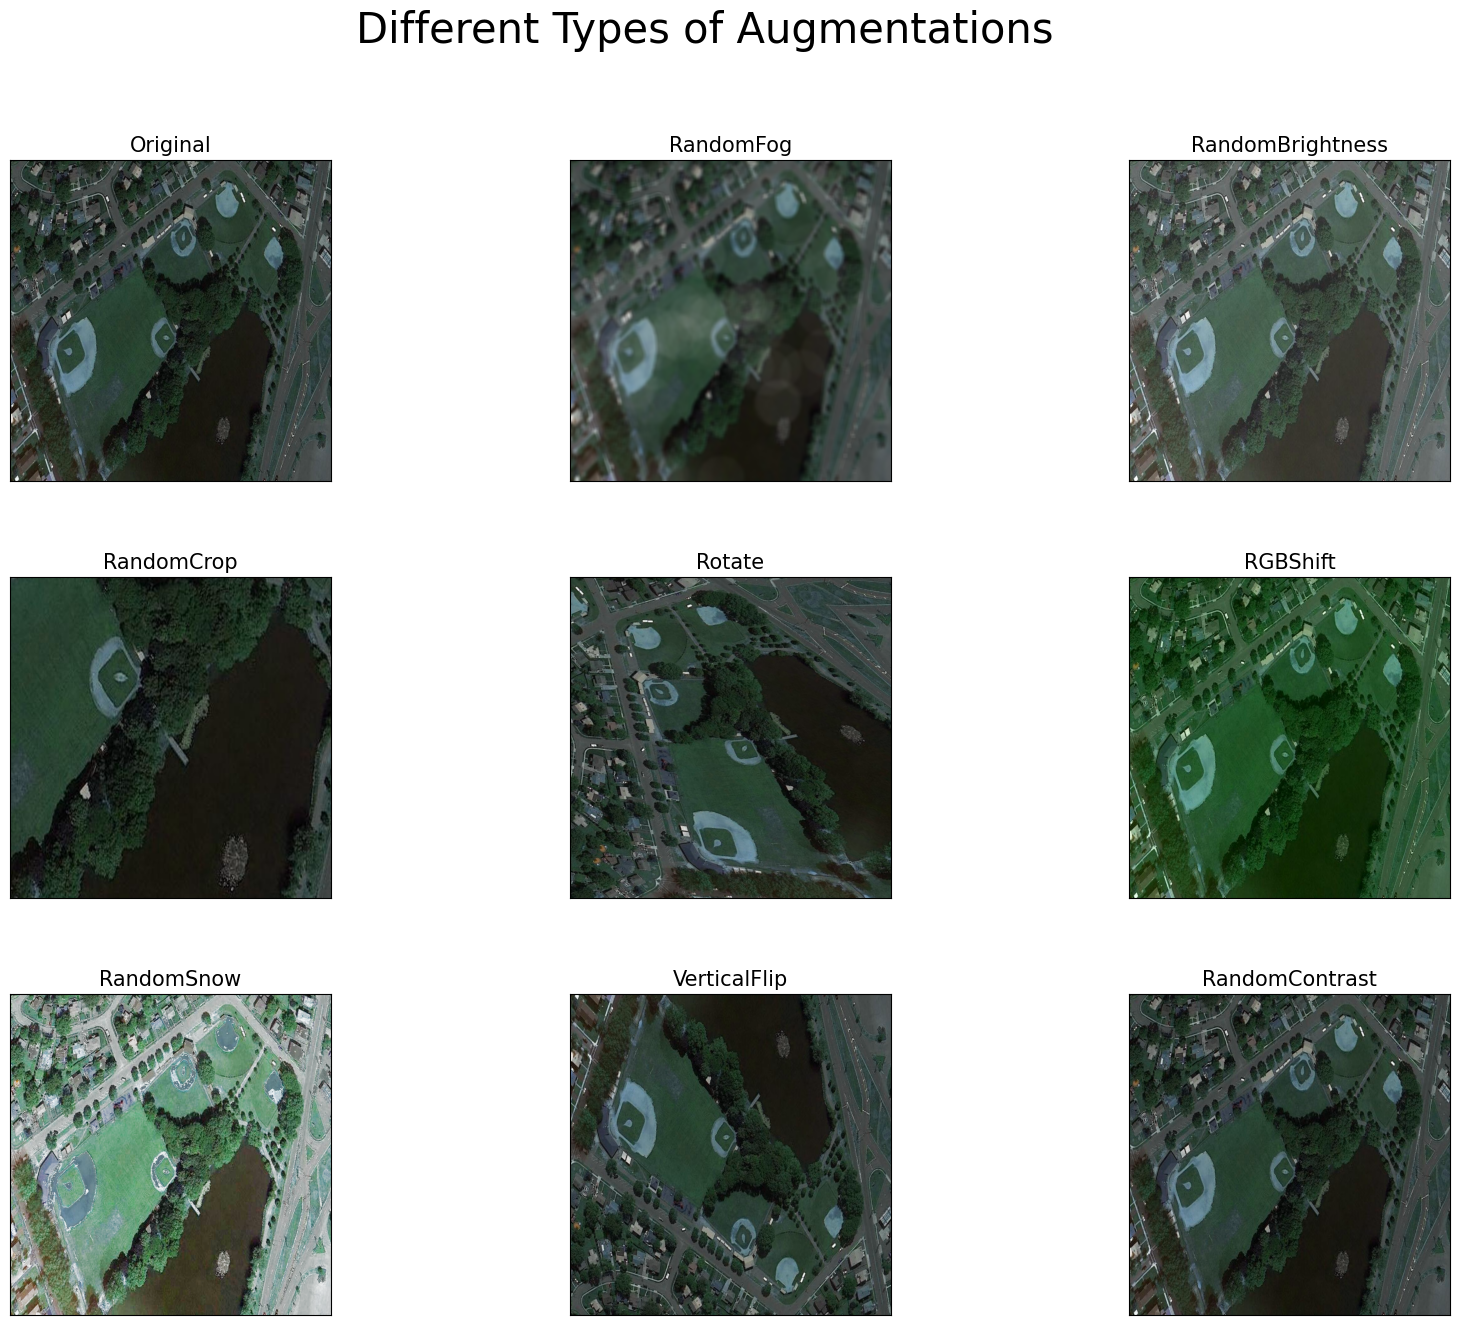

In [ ]:
chosen_img = read_img(img_id)

albumentation_list = [A.RandomFog(p=1),
                      A.RandomBrightness(p=1),
                      A.RandomCrop(p=1,height = 512, width = 512),
                      A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1),
                      A.RandomSnow(p=1),
                      A.VerticalFlip(p=1),
                      A.RandomContrast(limit = 0.5,p = 1)]

titles_list = ["Original",
               "RandomFog",
               "RandomBrightness",
               "RandomCrop",
               "Rotate",
               "RGBShift",
               "RandomSnow",
               "VerticalFlip",
               "RandomContrast"]

img_matrix_list = [chosen_img]
for aug_type in albumentation_list:
    img = aug_type(image = chosen_img)['image']
    img_matrix_list.append(img)

plot_multiple_img(img_matrix_list,
                  titles_list,
                  ncols = 3,
                  main_title="Different Types of Augmentations")

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


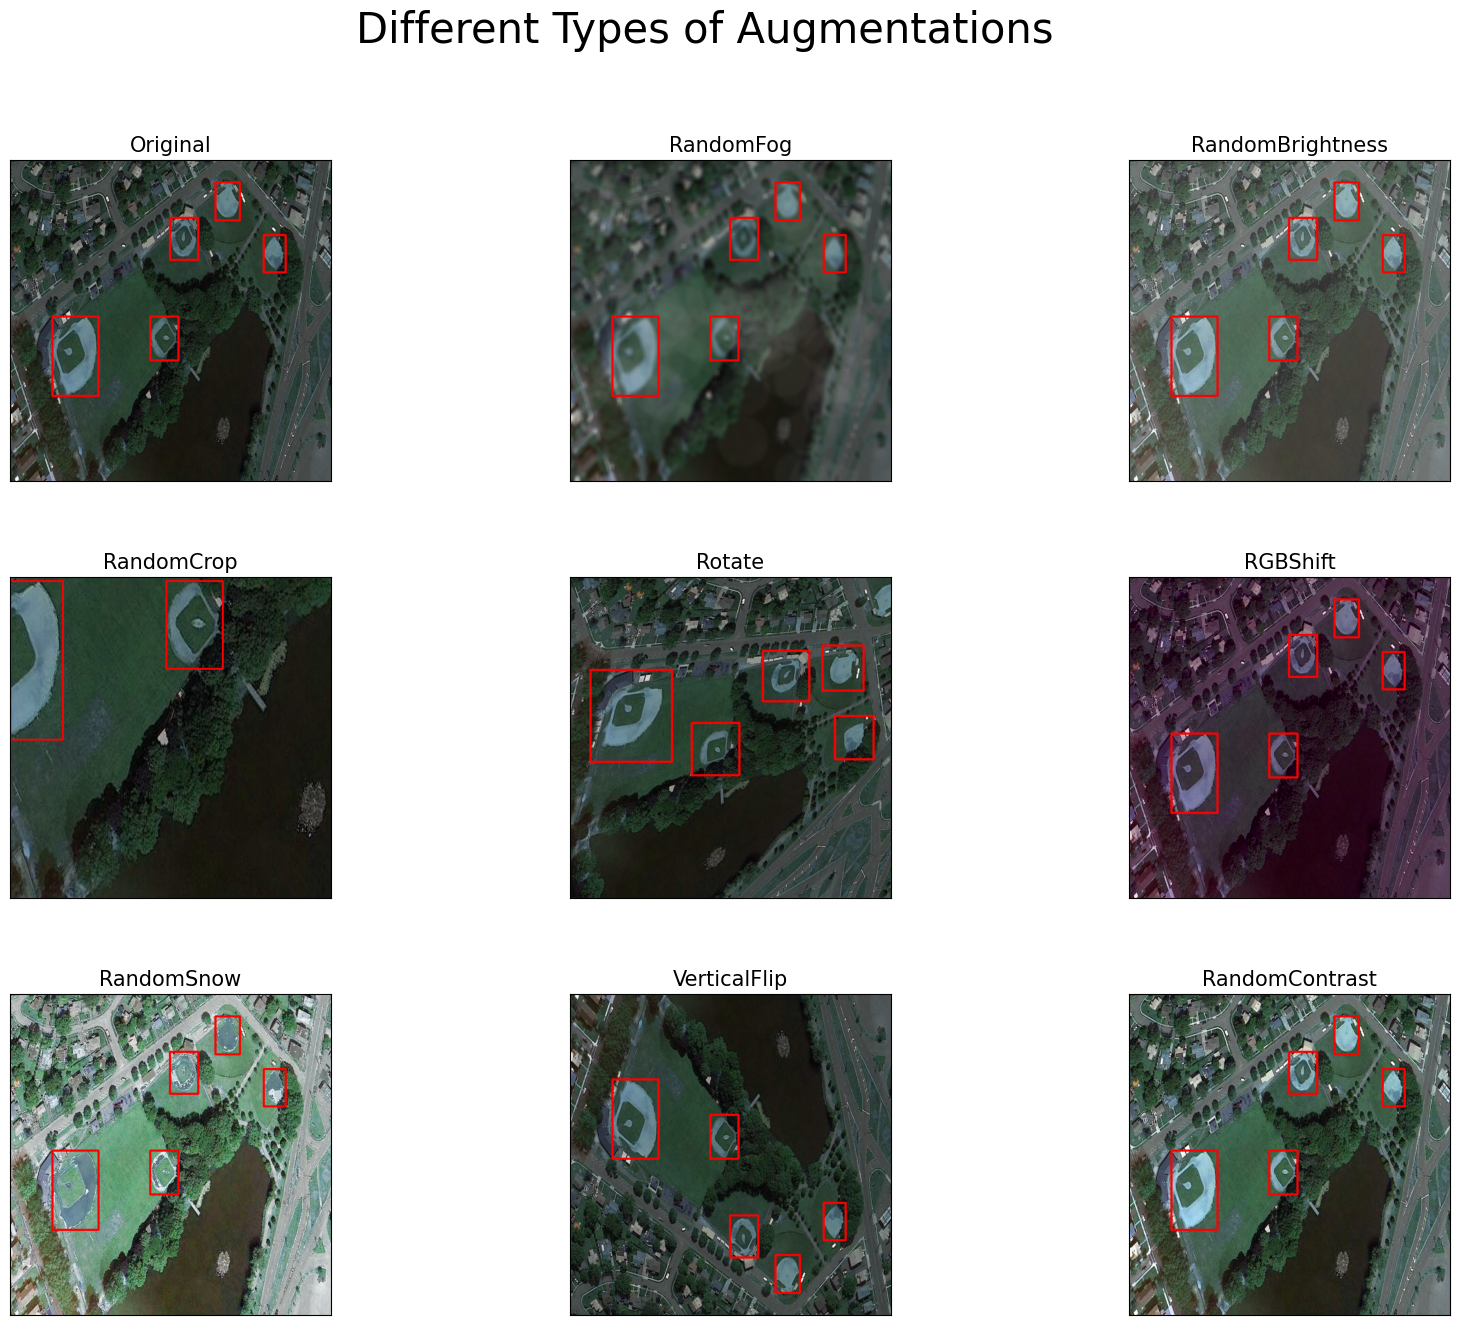

In [ ]:
chosen_img = read_img(img_id)
bboxes = read_bboxes(img_id)
bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}

albumentation_list = [A.Compose([A.RandomFog(p=1)], bbox_params=bbox_params),
                      A.Compose([A.RandomBrightness(p=1)], bbox_params=bbox_params),
                      A.Compose([A.RandomCrop(p=1, height=512, width=512)], bbox_params=bbox_params),
                      A.Compose([A.Rotate(p=1, limit=90)], bbox_params=bbox_params),
                      A.Compose([A.RGBShift(p=1)], bbox_params=bbox_params),
                      A.Compose([A.RandomSnow(p=1)], bbox_params=bbox_params),
                      A.Compose([A.VerticalFlip(p=1)], bbox_params=bbox_params),
                      A.Compose([A.RandomContrast(limit=0.5, p = 1)], bbox_params=bbox_params)
                     ]

titles_list = ["Original",
               "RandomFog",
               "RandomBrightness",
               "RandomCrop",
               "Rotate",
               "RGBShift",
               "RandomSnow",
               "VerticalFlip",
               "RandomContrast"]

img_matrix_list = [draw_rect(chosen_img, bboxes)]

for aug_type in albumentation_list:
    anno = aug_type(image=chosen_img, bboxes=bboxes, labels=np.ones(len(bboxes)))
    img  = draw_rect(anno['image'], anno['bboxes'])
    img_matrix_list.append(img)

plot_multiple_img(img_matrix_list,
                  titles_list,
                  ncols = 3,
                  main_title="Different Types of Augmentations")


**Data Splitting:**

In [34]:
# Define proportions
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


In [40]:
# Define paths
images_new_folder = '/content/extracted_folder/NWPU VHR-10 dataset/resized_images'  # Path to resized images folder
negative_folder = '/content/extracted_folder/NWPU VHR-10 dataset/negative image set'  # Path to negative image folder
train_folder = '/content/train'  # Path to the training folder
test_folder = '/content/test'  # Path to the testing folder

os.makedirs(os.path.join(train_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_folder, 'labels'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'labels'), exist_ok=True)

# Shuffle filenames for positive and negative samples separately
positive_filenames = [filename for filename in os.listdir(images_new_folder) if filename.endswith('.jpg')]
negative_filenames = [filename for filename in os.listdir(negative_folder) if filename.endswith('.jpg')]
random.shuffle(positive_filenames)
random.shuffle(negative_filenames)

In [41]:
# Split filenames into training, validation, and testing sets
positive_train_count = int(train_ratio * len(positive_filenames))
positive_val_count = int(val_ratio * len(positive_filenames))
positive_test_count = len(positive_filenames) - positive_train_count - positive_val_count

negative_train_count = int(train_ratio * len(negative_filenames))
negative_val_count = int(val_ratio * len(negative_filenames))
negative_test_count = len(negative_filenames) - negative_train_count - negative_val_count


In [42]:
# Move positive samples to training, validation, and testing folders
for i in range(positive_train_count):
    filename = positive_filenames[i]
    src_image = os.path.join(images_new_folder, filename)
    dst_image = os.path.join(train_folder, 'images', filename)
    shutil.move(src_image, dst_image)

for i in range(positive_train_count, positive_train_count + positive_val_count):
    filename = positive_filenames[i]
    src_image = os.path.join(images_new_folder, filename)
    dst_image = os.path.join(test_folder, 'images', filename)
    shutil.move(src_image, dst_image)

for i in range(positive_train_count + positive_val_count, len(positive_filenames)):
    filename = positive_filenames[i]
    src_image = os.path.join(images_new_folder, filename)
    dst_image = os.path.join(test_folder, 'images', filename)
    shutil.move(src_image, dst_image)

In [43]:
# Move negative samples to training, validation, and testing folders
for i in range(negative_train_count):
    filename = negative_filenames[i]
    src_image = os.path.join(negative_folder, filename)
    dst_image = os.path.join(train_folder, 'images', filename)
    shutil.move(src_image, dst_image)

for i in range(negative_train_count, negative_train_count + negative_val_count):
    filename = negative_filenames[i]
    src_image = os.path.join(negative_folder, filename)
    dst_image = os.path.join(test_folder, 'images', filename)
    shutil.move(src_image, dst_image)

for i in range(negative_train_count + negative_val_count, len(negative_filenames)):
    filename = negative_filenames[i]
    src_image = os.path.join(negative_folder, filename)
    dst_image = os.path.join(test_folder, 'images', filename)
    shutil.move(src_image, dst_image)

print("Data splitting completed successfully.")

Data splitting completed successfully.
